In [10]:
import pandas as pd
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [23]:
import pandas as pd
import pickle
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import streamlit as st

# Load and prepare data
def load_and_prepare_data(filename):
    data = pd.read_csv(filename, parse_dates=['Id_date_agr'])
    data['Id_date_agr'] = pd.to_datetime(data['Id_date_agr'], format='%Y%m')
    data = data.sort_values(by='Id_date_agr', ascending=False)
    data.set_index('Id_date_agr', inplace=True)
    return data

data = load_and_prepare_data('../datasets/final_pnl_gl_dataset-12-08-24_aggregated_per_month.csv')

# Function to filter data based on user selection
def filter_data(data, user_selection):
    filtered_data = data.copy()
    if user_selection is not None:
        
        for key, value in user_selection.items():
            if value is not None:
                filtered_data = filtered_data[filtered_data[key] == value].groupby('Id_date_agr').agg({
            'Montant(€)': 'sum',
            'Montant 7€': 'sum'
            })
    else:
        filtered_data = data.groupby('Id_date_agr').agg({
            'Montant(€)': 'sum',
            'Montant 7€': 'sum'
            })
    print(filtered_data.shape)    
    return filtered_data


# Function to train SARIMA model
def train_sarima_model(data):
    model = SARIMAX(data['Montant(€)'], 
                    order=(1, 2, 1), 
                    seasonal_order=(0, 2, 0, 12))
    results = model.fit(disp=False)
    return results

# Function to save model
def save_model(model, filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

# Function to load model
def load_model(filename):
    with open(filename, 'rb') as file:
        model = pickle.load(file)
    return model


C:\Users\075165\AppData\Local\Temp\ipykernel_15504\3890877140.py:9: DtypeWarning: Columns (0,8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filename, parse_dates=['Id_date_agr'])
C:\Users\075165\AppData\Local\Temp\ipykernel_15504\3890877140.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(filename, parse_dates=['Id_date_agr'])


In [2]:
##V2

import pandas as pd
import pickle
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import streamlit as st
from itertools import product
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Load and prepare data
def load_and_prepare_data(filename):
    data = pd.read_csv(filename, parse_dates=['Id_date_agr'])
    data['Id_date_agr'] = pd.to_datetime(data['Id_date_agr'], format='%Y%m')
    data = data.sort_values(by='Id_date_agr', ascending=False)
    data.set_index('Id_date_agr', inplace=True)
    return data

data = load_and_prepare_data('../datasets/final_pnl_gl_dataset-12-08-24_aggregated_per_month.csv')

# Function to filter data based on user selection
def filter_data(data, user_selection):
    filtered_data = data.copy()
    if user_selection is not None:
        
        for key, value in user_selection.items():
            if value is not None:
                filtered_data = filtered_data[filtered_data[key] == value].groupby('Id_date_agr').agg({
            'Montant(€)': 'sum',
            'Montant 7€': 'sum'
            })
    else:
        filtered_data = data.groupby('Id_date_agr').agg({
            'Montant(€)': 'sum',
            'Montant 7€': 'sum'
            })
    print(filtered_data.shape)    
    return filtered_data




# Function to get unique values for dropdowns based on filtered data
def get_unique_values(data, key):
    return [None] + sorted(data[key].unique().tolist())

# Function to train SARIMA model with parameters
def train_sarima_model(data, order, seasonal_order):
    model = SARIMAX(data['Montant(€)'], 
                    order=order, 
                    seasonal_order=seasonal_order)
    results = model.fit(disp=False)
    return results

# Function to evaluate SARIMA model
def evaluate_model(model, data):
    forecast = model.get_forecast(steps=len(data))
    forecast_mean = forecast.predicted_mean
    mae = mean_absolute_error(data['Montant(€)'], forecast_mean)
    rmse = np.sqrt(mean_squared_error(data['Montant(€)'], forecast_mean))
    r2 = r2_score(data['Montant(€)'], forecast_mean)
    return mae, rmse, r2

# Function to perform grid search
def grid_search(data, p_values, d_values, q_values, P_values, D_values, Q_values, S_values):
    best_aic = float('inf')
    best_r2 = -1 * float('inf')
    best_params = None
    best_model = None
    metrics = []

    for p, d, q, P, D, Q, S in product(p_values, d_values, q_values, P_values, D_values, Q_values, S_values):
        try:
            seasonal_order = (P, D, Q, S)
            order = (p, d, q)
            model = train_sarima_model(data, order, seasonal_order)
            mae, rmse, r2 = evaluate_model(model, data)
            aic = model.aic

            metrics.append({
                'order': order,
                'seasonal_order': seasonal_order,
                'aic': aic,
                'mae': mae,
                'rmse': rmse,
                'r2': r2
            })

            if aic < best_aic and r2 > best_r2:
                best_aic = aic
                best_r2 = r2
                best_params = {'order': order, 'seasonal_order': seasonal_order}
                best_model = model

        except Exception as e:
            print(f"Model fitting failed for order={order} and seasonal_order={seasonal_order}: {e}")
    
    return best_model, best_params, metrics

# Function to save model
def save_model(model, filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

# Function to load model
def load_model(filename):
    with open(filename, 'rb') as file:
        model = pickle.load(file)
    return model




C:\Users\075165\AppData\Local\Temp\ipykernel_20732\3986291329.py:15: DtypeWarning: Columns (0,8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filename, parse_dates=['Id_date_agr'])
C:\Users\075165\AppData\Local\Temp\ipykernel_20732\3986291329.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(filename, parse_dates=['Id_date_agr'])


In [3]:
# Function to forecast with trained model
def forecast_with_model(model, steps=12):
    forecast = model.get_forecast(steps=steps)
    
    forecast_mean = forecast.predicted_mean
    forecast_index = forecast_mean.index

    return pd.Series(forecast_mean, index=forecast_index)
    return pd.Series(forecast_mean, index=forecast_index)
# Function to plot forecast
def plot_forecast(data, forecast, title):
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Montant(€)'], label='Historical Budget', color='blue')
    plt.plot(forecast.index, forecast, label='Forecasted Budget', color='red')
    plt.title(f'Historical and Forecasted Budget: {title}')
    plt.xlabel('Date')
    plt.ylabel('Budget')
    plt.legend()
    plt.grid(True)
    plt.show()


(31, 2)
Performing grid search...


c:\Users\075165\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\075165\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\075165\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\075165\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\075165\AppData\Local\Programs\Python\Python

Model fitting failed for order=(2, 1, 1) and seasonal_order=(1, 2, 0, 12): LU decomposition error.


c:\Users\075165\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\075165\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\075165\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\075165\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\075165\AppData\Local\Pro

Best model parameters: {'order': (0, 0, 2), 'seasonal_order': (0, 1, 1, 12)}
Model saved as model_ID_Site_156.0.pkl


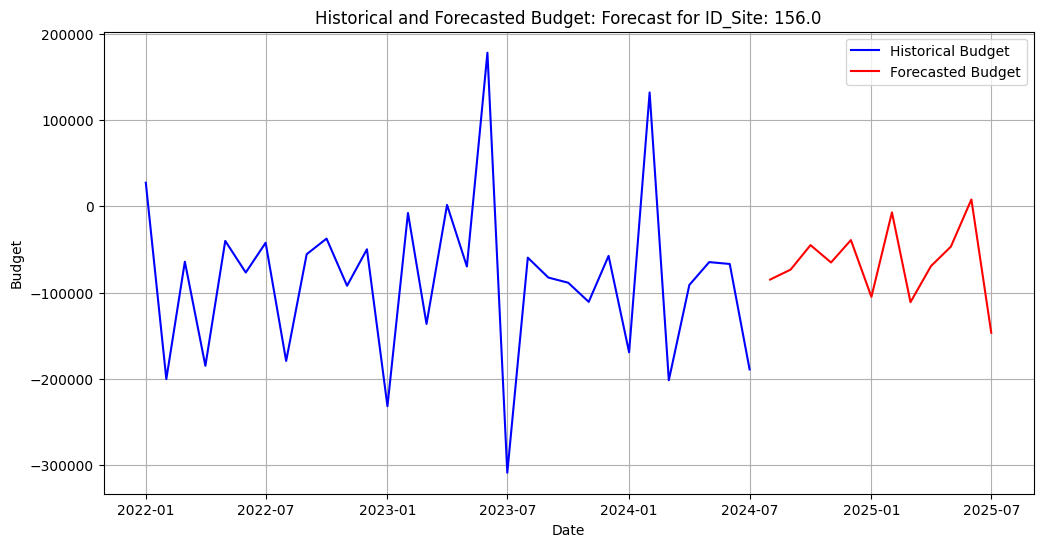

In [6]:
##V2

# Example user selection
user_selection = {
'ID_Site': 156.0,

}
# user_selection = None



# Filter data based on user selections
filtered_data = filter_data(data, user_selection)

# Hyperparameter grid
p_values = [0, 1,2]
d_values = [0, 1,2]
q_values = [0, 1,2]
P_values = [0, 1,2]
D_values = [0, 1,2]
Q_values = [0, 1,2]
S_values = [12]

# Perform grid search
print("Performing grid search...")
best_model, best_params, metrics = grid_search(filtered_data, p_values, d_values, q_values, P_values, D_values, Q_values, S_values)

if best_model:
    print(f"Best model parameters: {best_params}")

    # Save the best model
    model_filename = f"model_{'_'.join([f'{k}_{v}' for k, v in user_selection.items() if v])}.pkl"
    save_model(best_model, model_filename)
    print(f"Model saved as {model_filename}")

    # Forecast
    forecast = forecast_with_model(best_model)

    # Plot results
    title = f"Forecast for {'; '.join([f'{k}: {v}' for k, v in user_selection.items() if v])}"
    plot_forecast(filtered_data, forecast, title)
else:
    print("No suitable model found.")




(31, 2)
Loaded model from model_ID_Site_156.0.pkl


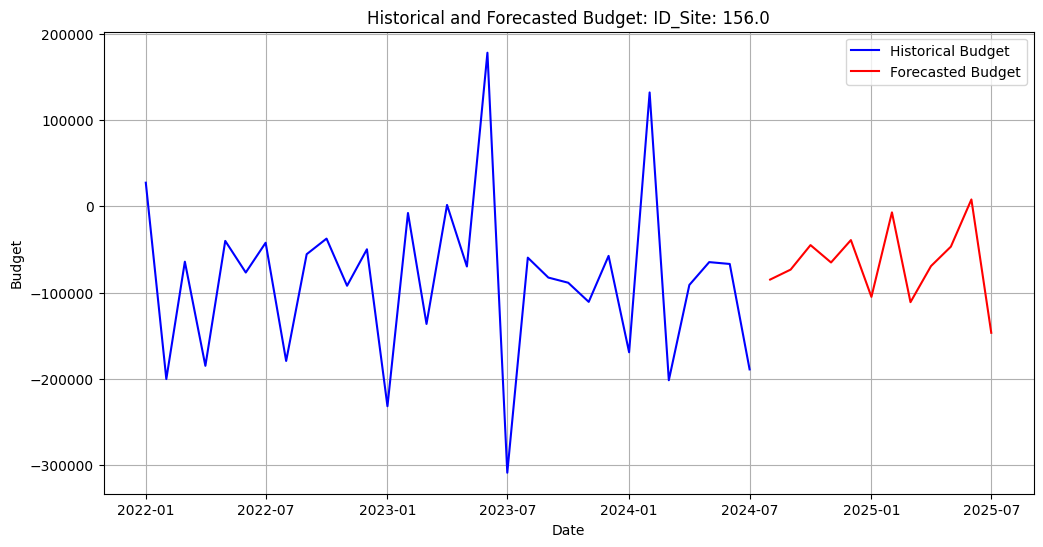

In [7]:
# Example user selection
user_selection = {
'ID_Site': 156.0,

}
# user_selection = None


# Filter data based on user selection
filtered_data = filter_data(data, user_selection)
if user_selection is not None:
# Define model filename based on user selection
    model_filename = f"model_{'_'.join([f'{k}_{v}' for k, v in user_selection.items() if v])}.pkl"
else: 
    model_filename = "model_.pkl"
try:
    # Try to load existing model
    model = load_model(model_filename)
    print(f"Loaded model from {model_filename}")
except FileNotFoundError:
    print(f"Model not found. Training new model...")
    
    # Train SARIMA model
    model = train_sarima_model(filtered_data)
    
    # Save the newly trained model
    save_model(model, model_filename)
    print(f"Model saved as {model_filename}")

# Forecast
forecast = forecast_with_model(model)

# Plot results
if user_selection is not None:
    plot_forecast(filtered_data, forecast, ' / '.join([f'{k}: {v}' for k, v in user_selection.items() if v and user_selection]))
else:
    plot_forecast(filtered_data, forecast, ' / all data')



# Call the main function with user selection



Id_date_agr
2022-01-01     27509.342147
2022-01-01     27431.864698
2022-01-01     27408.529327
2022-01-01     27699.890000
2022-01-01     27417.706948
                  ...      
2024-07-01   -188848.576277
2024-07-01   -188848.576277
2024-07-01   -188875.003014
2024-07-01   -188843.552782
2024-07-01   -188287.040109
Name: Montant(€), Length: 1905344, dtype: float64